# Random Cut Forest

Data source: [kaggle_DailyDelhiClimate](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data?select=DailyDelhiClimateTrain.csv])

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import RandomCutForest

In [2]:
# Load data
# Load a subset of the data
data = pd.read_csv("DailyClimate.csv").loc[1300:,:]

print(data.shape)
data.head()

(162, 5)


,date,meantemp,humidity,wind_speed,meanpressure
1300,2016-07-24,31.437500,72.250000,2.431250,946.312500
1301,2016-07-25,31.937500,69.125000,2.912500,1001.875000
1302,2016-07-26,30.312500,82.000000,6.485714,1003.125000
1303,2016-07-27,28.312500,88.250000,4.293750,1004.625000
1304,2016-07-28,29.533333,81.333333,5.186667,1002.066667


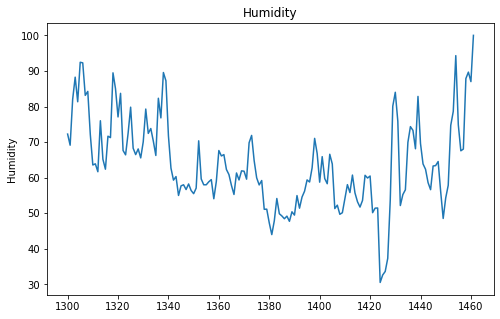

In [3]:
# Line plot
plt.figure(figsize=(8,5))
plt.plot(data["humidity"])
plt.title("Humidity")
plt.ylabel("Humidity")
plt.show()

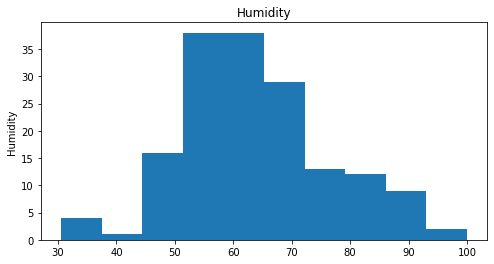

In [4]:
# Histogram
plt.figure(figsize=(8,4))
plt.hist(data["humidity"])
plt.title("Humidity")
plt.ylabel("Humidity")
plt.show()

## Train the model

In [25]:
# After creating a prefix in the bucket
# Set the bucket
bucket = "sagemaker-tutorial-rnd"
# Check the region name
region = boto3.session.Session().region_name
print(region)

# Set the output path for the saved model
prefix = "RCF"
output_path = f"s3://{bucket}/{prefix}/saved_model"

ap-southeast-1


In [26]:
base_job_name = "rcf-climate"

session = sagemaker.Session()

# Create estimator
RCF = RandomCutForest(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m4.xlarge',
    num_samples_per_tree=50,
    num_trees=50,
    feature_dim=1,
    base_job_name=base_job_name,
    use_spot_instances=False,
    max_run=600,,
    data_location=f"s3://{bucket}/{prefix}/train",
    output_path=f"s3://{bucket}/{prefix}/saved_model"
)

# Save the dataset to S3 and fit the model
RCF.fit(RCF.record_set(data["humidity"].values.reshape(-1, 1))) 

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-03 08:26:14 Starting - Starting the training job...
2022-03-03 08:26:40 Starting - Preparing the instances for trainingProfilerReport-1646295974: InProgress
.........
2022-03-03 08:28:13 Downloading - Downloading input data
2022-03-03 08:28:13 Training - Downloading the training image......
2022-03-03 08:29:13 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/03/2022 08:29:14 INFO 140011112511296 integration.py:636] worker started
[03/03/2022 08:29:14 INFO 140011112511296] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective

## Deploy the model

In [28]:
RCF_predictor = RCF.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name=base_job_name
)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------!

In [29]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

In [30]:
RCF_predictor.serializer = CSVSerializer()
RCF_predictor.deserializer = JSONDeserializer()

## Model prediction

In [34]:
# Model prediction
data_np = data["humidity"].values.reshape(-1, 1)
pred = RCF_predictor.predict(data_np)
pred

{'scores': [{'score': 1.1226885251},
  {'score': 1.0992224982},
  {'score': 1.2441850282},
  {'score': 1.2996546669},
  {'score': 1.2237357896},
  {'score': 1.3570268283},
  {'score': 1.3393723712},
  {'score': 1.2380481387},
  {'score': 1.2549206276},
  {'score': 1.1308338329},
  {'score': 1.0440851344},
  {'score': 1.0437271022},
  {'score': 1.0170995791},
  {'score': 1.1937951944},
  {'score': 1.0587283907},
  {'score': 1.028682458},
  {'score': 1.1053922171},
  {'score': 1.1012897762},
  {'score': 1.3050607502},
  {'score': 1.2682640321},
  {'score': 1.1901218759},
  {'score': 1.2436568766},
  {'score': 1.0756794599},
  {'score': 1.0568618471},
  {'score': 1.1275932077},
  {'score': 1.2109377425},
  {'score': 1.0866020881},
  {'score': 1.0572168355},
  {'score': 1.0821647727},
  {'score': 1.0584977915},
  {'score': 1.0918856459},
  {'score': 1.2106514408},
  {'score': 1.121086571},
  {'score': 1.1443015607},
  {'score': 1.0939015584},
  {'score': 1.0566364735},
  {'score': 1.230489

In [35]:
pred_score = [n['score'] for n in pred['scores']]
data["score"] = pred_score
data.head(3)

,date,meantemp,humidity,wind_speed,meanpressure,score
1300,2016-07-24,31.4375,72.250,2.431250,946.3125,1.122689
1301,2016-07-25,31.9375,69.125,2.912500,1001.8750,1.099222
1302,2016-07-26,30.3125,82.000,6.485714,1003.1250,1.244185


In [36]:
data.to_csv("data_pred.csv")

Delete the endpoint if not needed anymore.